In [65]:
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import scipy.optimize
import scipy.interpolate
import seaborn as sns

red, blue, green = sns.color_palette('Set1', 3)

from cnv_simulation import CNVsimulator_simpleWF, CNVsimulator_simpleChemo

In [2]:
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi
import torch

Prior over model parameters. Model parameters are CNV fitness effects and CNV mutation rates. Will use a uniform distribution.

In [3]:
prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

Simulator:

the input parameter set should have either shape (1,N) or (N), and the output must have shape (1,M) or (M)  
Here, N=2, M=25

In [4]:
EvoModel = "WF"
def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    reps = 1
    if EvoModel == "WF":
        states = CNVsimulator_simpleWF(reps = reps, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, seed=None, parameters=cnv_params)
    if EvoModel == "Chemo":
        states = CNVsimulator_simpleChemo(reps = reps, A_inoculation=A_inoculation, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, S0=S0, y=y, τ=τ, seed=None, parameters=cnv_params)
        
    return states

In [5]:
#other parameters needed for model 
# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.001 
m_snv=1e-5 
reps=1
generation = np.array(range(0,268))
# chemostat parameters
A_inoculation = 1e5
S_init = .800
D=0.12
μA=0.45
k=.103
y=32445000
S0=.800
τ=1/10

In [6]:
#make sure simulator and prior adhere to sbi requirementst
simulator, prior = prepare_for_sbi(CNVsimulator, prior)

Presimulated data

In [7]:
# used sbi v0.13.2 to make presim data
# WF_number_presimulated = 100000
# WF_theta_presimulated = prior.sample((WF_number_presimulated,))

# batches = torch.split(WF_theta_presimulated, 1, dim=0)
# x_presimulated = []
# for t in batches:
#     x_presimulated.append(simulator(t))
# x_presimulated = torch.cat(x_presimulated, dim=0)

# print('Shape of x_presimulated    : ', x_presimulated.shape)

# #save presimulated thetas and data to csvs
# np.savetxt("WF_presimulated_theta_100000_3.csv", WF_theta_presimulated.numpy(), delimiter=',')
# np.savetxt("WF_presimulated_data_100000_3.csv", x_presimulated.numpy(), delimiter=',')

In [8]:
# EvoModel = "Chemo"
# Chemo_number_presimulated = 5000 #try more?
# Chemo_theta_presimulated = prior.sample((Chemo_number_presimulated,))

# batches = torch.split(Chemo_theta_presimulated, 1, dim=0)
# x_presimulated = []
# for t in batches:
#     x_presimulated.append(simulator(t))
# x_presimulated = torch.cat(x_presimulated, dim=0)

# print('Shape of x_presimulated    : ', x_presimulated.shape)

# #save presimulated thetas and data to csvs
# np.savetxt("Chemo_presimulated_theta_5000.csv", Chemo_theta_presimulated.numpy(), delimiter=',')
# np.savetxt("Chemo_presimulated_data_5000.csv", x_presimulated.numpy(), delimiter=',')

In [9]:
# save presimulated data to csv
#np.savetxt("chemostat_presimulated_1000.csv", x_presimulated.numpy(), delimiter=',')
# np.savetxt("WF_presimulated_100000.csv", x_presimulated.numpy(), delimiter=',')

In [10]:
# read in presimulated chemostat data or WF data
# theta_presimulated = torch.tensor(np.genfromtxt('Chemo_presimulated_theta_1000.csv',delimiter=',')).type('torch.FloatTensor')
# x_presimulated = torch.tensor(np.genfromtxt('Chemo_presimulated_data_1000.csv',delimiter=',')).type('torch.FloatTensor')
# print('Shape of x_presimulated chemostat data    : ', x_presimulated.shape)

# read in presimulated WF data
theta_presimulated = torch.tensor(np.genfromtxt('./presimulated_data/WF_presimulated_theta_100000_1.csv',delimiter=',')).type('torch.FloatTensor')
x_presimulated = torch.tensor(np.genfromtxt('./presimulated_data/WF_presimulated_data_100000_1.csv',delimiter=',')).type('torch.FloatTensor')
print('Shape of x_presimulated' + EvoModel + 'data    : ', x_presimulated.shape)

Shape of x_presimulatedWFdata    :  torch.Size([100000, 25])


Run inference

In [11]:
inference = SNPE(prior, density_estimator='maf')

In [12]:
density_estimator = inference.append_simulations(theta_presimulated, x_presimulated).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 29 epochs.


Observation:  
The shape must be either (1,M) or just (M).  
Here, M = 25

Perform amortized inference on the simulated observations over each parameter regime - that is, first run inference (above), then evaluate the posterior for each of the observations (without re-running inference)

For each observation:
* obtain MAP
    * get euclidean dist between MAP and simulation parameter
* plot marginal histograms
    * get marginal 95% HDIs
* plot joint density
    * 50%, 95%, 99% HDRs
* perform posterior predictive check:
    * generate predictions with MAP
    * compute distance between prediction and observation
    * Calculate AIC
    * get median distance of predictions from observation -> this should actually be median distance using many MAPs from independent rounds
* Draw 50 samples from posterior 
    * generate predictions
    * compute distance between prediction and observation
    * Calculate DIC
    

Perform amortized inference on the  observations - that is, first run inference, then evaluate the posterior for each of the observations (without re-running inference)

Text(130, 0.5, 'Simulated observation\nmodel: WF\nlog10(CNV fitness): -1.0\nlog10(CNV mutation rate): -5.0\nSNV fitness:0.001\nSNV mutation rate:1e-05')

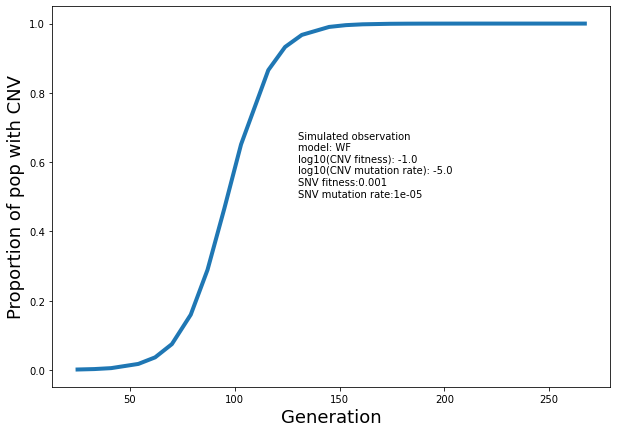

In [13]:
obs_file = np.genfromtxt('WF_simulated_data.csv',delimiter=',')
observation = obs_file[0,0:25]
true_params = torch.tensor(obs_file[0,25:27]).type('torch.FloatTensor')
labels_params = ['CNV fitness effect', 'CNV mutation rate']

gens=np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])

title='Simulated observation\nmodel: WF' +'\nlog10(CNV fitness): ' + str(np.asarray(true_params[0])) + '\nlog10(CNV mutation rate): ' + str(np.asarray(true_params[1])) + '\nSNV fitness:' + str(s_snv) + '\nSNV mutation rate:' + str(m_snv)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(gens,observation.reshape(-1),linewidth=4)
#fig.tight_layout()
plt.xlabel("Generation", size=18)
plt.ylabel("Proportion of pop with CNV", size=18)
ax.text(x=130,y=0.5, s=title)
#plt.savefig('obs_example.pdf')

Distance function for distance between posterior parameters and observation parameters:

 
$$
d(x,y) = \sqrt{((\mu_x- \mu_y)^2 + (s_x - s_y)^2 }
$$

where  
$\mu$ = mutation rate   
$s$ = fitness effect


In [15]:
# distance between a simulation and "observation" 
def param_distance(simulation, observation):
    # simulation and observation are both arrays of parameters of size 2
    simulation = np.power(10,simulation)
    observation = np.power(10, observation)
    d = ((simulation[0]-observation[0])**2 + (simulation[1]-observation[1])**2)**0.5
    return d

In [72]:
posterior_samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(posterior_samples, x=observation)
map_params = posterior.map(observation)
map_dist = param_distance(map_params,true_params)
map_log_prob = posterior.log_prob(map_params, x=observation)
s_est, μ_est = map_params
s_est, μ_est = float(s_est), float(μ_est)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/sbi/inference/posteriors/base_posterior.py:653: UserWarning: This method for obtaining the MAP estimate was introduced recently (sbi v0.15.0) and has not been tested extensively yet. You might have to tune the hyperparameters, especially `num_iter` and `learning_rate`. If you experience problems, please create an issue on Github: https://github.com/mackelab/sbi/issues
  "This method for obtaining the MAP estimate was introduced recently "


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
fitness_samples = np.asarray(posterior_samples[:,0])
mut_samples = np.asarray(posterior_samples[:,1])

#calculations kde
ymin = fitness_samples.min()
ymax = fitness_samples.max()
xmin = mut_samples.min()
xmax = mut_samples.max()

s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
s_range = np.vstack((s_range, np.repeat(true_params[0], 100)))
μ_range = np.vstack((μ_range, np.repeat(true_params[1], 100)))
s_range = np.vstack((s_range, np.repeat(s_est, 100)))
μ_range = np.vstack((μ_range, np.repeat(μ_est, 100)))
s_range = s_range[np.argsort(s_range[:, 0])]
μ_range = μ_range[np.argsort(μ_range[:, 0])]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)

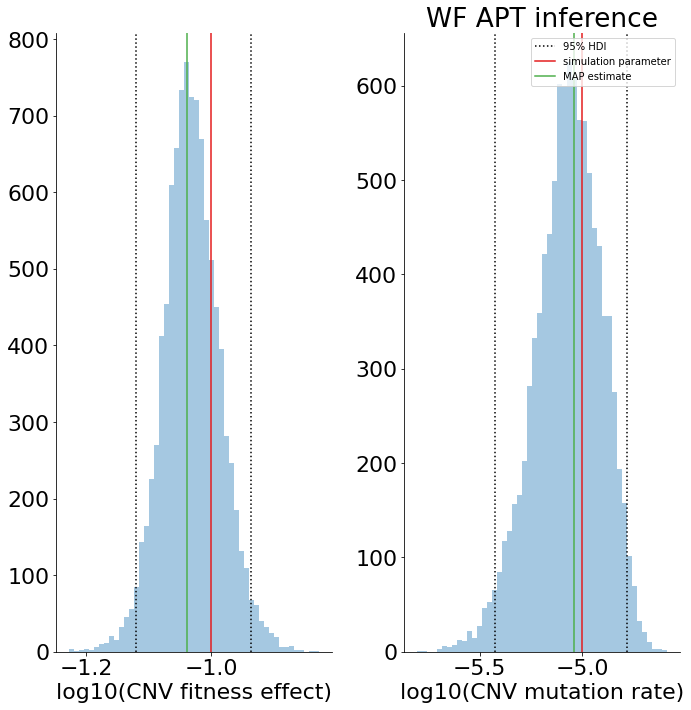

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# marginal
sns.distplot(fitness_samples, bins=50, kde=False, ax=axes[0])
sns.distplot(mut_samples, bins=50, kde=False, ax=axes[1]) 

#marginal 95% hdis
fit_95hdi_low,fit_95hdi_high  = np.quantile(fitness_samples, q=[0.025,0.975])
mut_95hdi_low,mut_95hdi_high  = np.quantile(mut_samples, q=[0.025,0.975])
axes[0].axvline(fit_95hdi_low, color='k', linestyle=':')
axes[0].axvline(fit_95hdi_high, color='k', linestyle=':')
axes[1].axvline(mut_95hdi_low, color='k', linestyle=':')
axes[1].axvline(mut_95hdi_high, color='k', label="95% HDI", linestyle=':')


# MAP and true params
axes[0].axvline(true_params[0], color=red)
axes[0].axvline(s_est, color=green)
axes[1].axvline(true_params[1], color=red, label="simulation parameter")
axes[1].axvline(μ_est, color=green, label="MAP estimate")


axes[0].set(xlabel='log10(CNV fitness effect)')
axes[1].set(xlabel='log10(CNV mutation rate)')


fig.tight_layout()
plt.legend(loc='upper right', prop={'size': 10})
plt.title('WF APT inference')
sns.despine()

/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


Text(0.5, 1.0, 'Wright-Fisher SNPE joint posterior distribution')

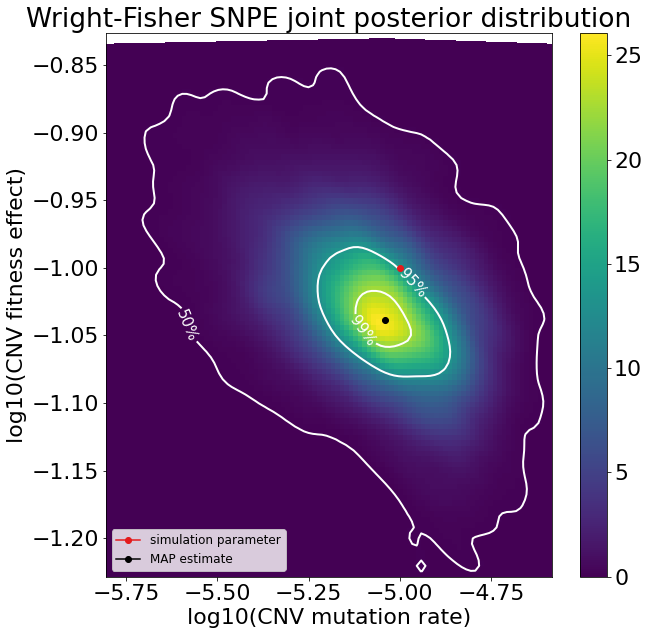

In [58]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(μ_range.min(),μ_range.max())
ax.set_ylim(s_range.min(),s_range.max())
cf=ax.pcolormesh(μ_range, s_range, density)#, shading='auto') -> make probability 2D
fig.colorbar(cf,ax=ax)
CS = ax.contour(μ_range, s_range, density, levels = np.quantile(density, q=[0.5,0.95,0.99]),
                colors=('w',),linestyles=('-',),linewidths=(2,))
fmt = {}
strs = [ '50%', '95%', '99%']
for l,s in zip( CS.levels, strs ):
    fmt[l] = s
ax.clabel(CS, CS.levels, fmt=fmt, inline=1, fontsize=15)
ax.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter")
ax.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate")
ax.legend(loc='lower left', prop={'size': 12})
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("Wright-Fisher SNPE joint posterior distribution")


Distance between simulation and observation:

 
$$
d(x,y) = \sum_i (x_i - y_i)^2 
$$

where   
i = timepoint 



In [59]:
def distance(obs, exp):
    return np.sum((obs-exp)**2)

In [67]:
#draw from posterior
indx=np.random.choice(posterior_samples.shape[0], 50, replace=False)
params_post = posterior_samples[indx, :]
logprob_post = log_probability[indx]
# simulate based on drawn params, calculate distance
dist_posterior = []
evo_reps_posterior = []
for i in range(50):
    obs_post = CNVsimulator(params_post[i,:])
    evo_reps_posterior.append(obs_post)
    dist_posterior.append(distance(obs_post,observation))

In [61]:
evo_reps_posterior = np.vstack(evo_reps_posterior)
dist_posterior = np.vstack(dist_posterior)

Text(0.5, 0.98, 'WF, SNPE')

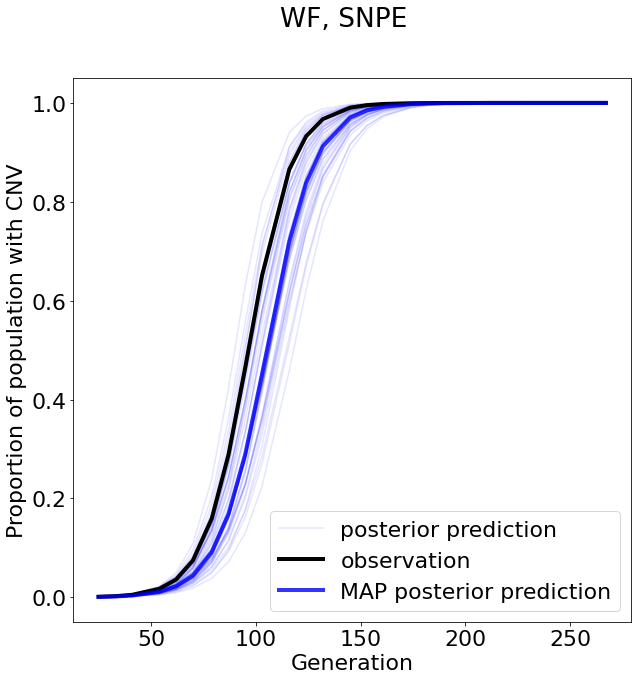

In [62]:
reps=1
post_prediction_map = CNVsimulator(map_params)

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.set_ylim(0,1)
for i in range(49) :
    ax.plot(gens, evo_reps_posterior[i,:], color='blue',alpha=0.1)
ax.plot(gens, evo_reps_posterior[49,:], color='blue',alpha=0.1, label = 'posterior prediction')
ax.plot(gens,observation.reshape(-1),linewidth=4, label = 'observation', color = 'black')
ax.plot(gens,post_prediction_map.reshape(-1),linewidth=4, alpha=0.8, label = 'MAP posterior prediction', color='blue')
ax.legend(loc='lower right')
ax.set_xlabel('Generation')
ax.set_ylabel('Proportion of population with CNV')
plt.suptitle('WF, SNPE')

Compute AIC and dic

In [80]:
aic = map_log_prob + 2*2
dic = 2*(posterior.log_prob(torch.tensor([fitness_samples.mean(), mut_samples.mean()]),x=observation) - (1/50)*logprob_post.sum())

In [64]:
def format(value):
    return "%.12f" % value

f= open("est_real_params.csv","a+")
f.write(EvoModel+',sbi,'+','.join(str(format(j)) for j in (true_params[0],s_est,true_params[1],μ_est,s_snv,m_snv,
                                                           map_dist,
                                                           fit_95hdi_low,fit_95hdi_high,
                                                           mut_95hdi_low,mut_95hdi_high,
                                                          aic, dic)) + '\n')
f.close() 

NameError: name 'med_dist_posterior' is not defined

In [ ]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))